<p style="text-align:right;">2020-10-08<p>
<h1><center>A1: Data Curation</center></h1>
This notebook gathers and analyzes data from Wikipedia (in English) between Jan 2008 and Aug 2020.

___

# Getting the data

## Imports

In [16]:
import os
import requests
import glob

## Config

In [17]:
DATA_FOLDER_PATH = "data"

ENDPOINT_PAGECOUNTS = "https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}"
BASE_PARAMS_PAGECOUNTS = {"project" : "en.wikipedia.org", 
                      "granularity" : "monthly"}

ENDPOINT_PAGEVIEWS = "https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"
BASE_PARAMS_PAGEVIEWS = {"project" : "en.wikipedia.org",
                         "agent" : "user",
                         "granularity" : "monthly"}

DEFAULT_HEADERS = {"User-Agent": "https://github.com/igv-uw",
                   "From": "igiarizio@uw.edu"}

## Methods to request and store the data
The following methods format the request to each API, and return its content.  
They also save the data to the proper files with the proper filenames and path.

In [18]:
def req_from_params(api_name, parameters, headers=None):
    """Generates a request using the parameters and the API name passed."""
    if api_name == "pagecounts":
        parameters = {**BASE_PARAMS_PAGECOUNTS, **parameters}
        endpoint = ENDPOINT_PAGECOUNTS
        
    elif api_name == "pageviews":
        parameters = {**BASE_PARAMS_PAGEVIEWS, **parameters}
        endpoint = ENDPOINT_PAGEVIEWS
        
    else:
        raise Exception("Invalid api_name.")
    
    if headers is None:
        headers = {}
    headers = {**DEFAULT_HEADERS, **headers}
    
    r = requests.get(endpoint.format(**parameters), headers=headers)
    return r

def req_to_file(r, filename):
    """Writes the response of the request to a file."""
    with open(filename, 'w') as f:
        f.write(r.text)

def get_filepath(base_path, api_name, access_type, dates):
    """Returns a proper filepath for the json files generated."""
    filename = f"{api_name}_{access_type}_{dates['start'][:6]}-{dates['end'][:6]}.json"
    filepath = os.path.join(base_path, filename)
    return filepath

def create_clear_filepath(filepath):
    """Creates a folder if it not exists. If not, it removes all files."""
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    files = glob.glob(os.path.join(filepath, "*"))
    for f in files:
        os.remove(f)

Creates an empty folder to store the data it does not exist. If it exists,
it deletes the content of the folder.

In [19]:
create_clear_filepath(DATA_FOLDER_PATH)

Requests and saves the needed data for the "Pagecounts" API.  
For this, it uses the methods defined above. It first makes the request,
generates a proper filepath and finally, writes the file content to a json
file in it.

In [20]:
api_name = "pagecounts"
dates = {"start" : "2008010100", "end": "2016080100"}
access_types = ["desktop-site", "mobile-site"]
for access_type in access_types: 
    r = req_from_params(api_name, {"access-site": access_type, **dates})
    filepath = get_filepath(DATA_FOLDER_PATH, api_name, access_type, dates)
    req_to_file(r, filepath)

Requests and saves the needed data for the "Pageviews" API.  
For this, it uses the defined methods above. It first makes the request,
generates a proper filepath and finally, writes the file content to a json
file in it.

In [21]:
api_name = "pageviews"
dates = {"start" : "2008010100", "end": "2020090100"}
access_types = ["desktop", "mobile-web", "mobile-app"]
for access_type in access_types: 
    r = req_from_params(api_name, {"access": access_type, **dates})
    filepath = get_filepath(DATA_FOLDER_PATH, api_name, access_type, dates)
    req_to_file(r, filepath)

___

# Analyzing the data

## Imports

In [22]:
import pandas as pd
import json
import matplotlib.pyplot as plt

## Reading the data
The following code reads and concatenates all json files in the data folder.
It also includes the name of the original API as an additional column.

In [23]:
json_files = glob.glob(os.path.join(DATA_FOLDER_PATH, "*.json"))

dfs = []
for file in json_files:
    with open(file) as f:
        full_json = json.load(f)
        items_json = full_json['items']
        df = pd.DataFrame(items_json)
        
        if 'pageviews' in file:
            df['api_origin'] = 'pageviews'
        elif 'pagecounts' in file:
            df['api_origin'] = 'pagecounts'
        dfs.append(df)

wiki_df = pd.concat(dfs)
wiki_df.reset_index(inplace=True, drop=True)

Parses the timestamp into a proper data format and combines some columns
that come from different APIs, but that serve the same purpose (in this case,
"access" and "access-site", and "views" and "count").

In [24]:
wiki_df['timestamp_parsed'] = pd.to_datetime(wiki_df.timestamp, format='%Y%m%d%H')

wiki_df['access_combined'] = wiki_df.access
wiki_df.loc[wiki_df.access_combined.isna(), 'access_combined'] = wiki_df['access-site']

wiki_df['views_combined'] = wiki_df.views
wiki_df.loc[wiki_df.views.isna(), 'views_combined'] = wiki_df['count']

Groups the data by timestamp and puts the number of views for each access type
as columns.

In [25]:
wiki_grouped = wiki_df.groupby(['timestamp_parsed', 'api_origin', 'access_combined']).views_combined.first().unstack().unstack()
wiki_grouped.dropna(axis=1, how='all', inplace=True)
wiki_grouped.columns = wiki_grouped.columns.map('{0[1]}_{0[0]}'.format).str.replace('-', '_')
wiki_grouped.reset_index(inplace=True)

Small preview of how the DataFrame is formatted.

In [26]:
wiki_grouped.head(5)

,timestamp_parsed,pageviews_desktop,pagecounts_desktop_site,pageviews_mobile_app,pagecounts_mobile_site,pageviews_mobile_web
0,2008-01-01,NaN,4.930903e+09,NaN,NaN,NaN
1,2008-02-01,NaN,4.818394e+09,NaN,NaN,NaN
2,2008-03-01,NaN,4.955406e+09,NaN,NaN,NaN
3,2008-04-01,NaN,5.159162e+09,NaN,NaN,NaN
4,2008-05-01,NaN,5.584691e+09,NaN,NaN,NaN


Generates the required total columns ("pageview_mobile_views" and
"pageview_all_views") and renames some other columns to fit the assignment
requirements.

In [27]:
wiki_grouped['pageview_mobile_views'] = wiki_grouped.pageviews_mobile_app + wiki_grouped.pageviews_mobile_web
wiki_grouped['pageview_all_views'] = wiki_grouped.pageview_mobile_views + wiki_grouped.pageviews_desktop

wiki_grouped['pagecount_all_views'] = wiki_grouped.pagecounts_desktop_site + wiki_grouped.pagecounts_mobile_site

rename_cols = {'pageviews_desktop' :'pageview_desktop_views',
               'pagecounts_desktop_site': 'pagecount_desktop_views',
               'pagecounts_mobile_site': 'pagecount_mobile_views'}

wiki_grouped.rename(columns=rename_cols, inplace=True)

Creates a new DataFrame with only the necessary information for the output
file. It also creates a "year" and a "month" column from the timestamp column.

In [28]:
wiki_formatted = wiki_grouped.fillna(0).copy()

wiki_formatted['year'] = wiki_formatted.timestamp_parsed.dt.year
wiki_formatted['month'] = wiki_formatted.timestamp_parsed.dt.month

final_cols = ['year', 'month', 'pagecount_all_views', 
              'pagecount_desktop_views', 'pagecount_mobile_views',
              'pageview_all_views', 'pageview_desktop_views',
              'pageview_mobile_views']

wiki_formatted = wiki_formatted[final_cols].copy()

out_filename = 'en-wikipedia_traffic_200712-202008.csv'
wiki_formatted.to_csv(out_filename, sep=';')

Generates the required graph and formats it to have the proper title, legend,
line styles, etc.

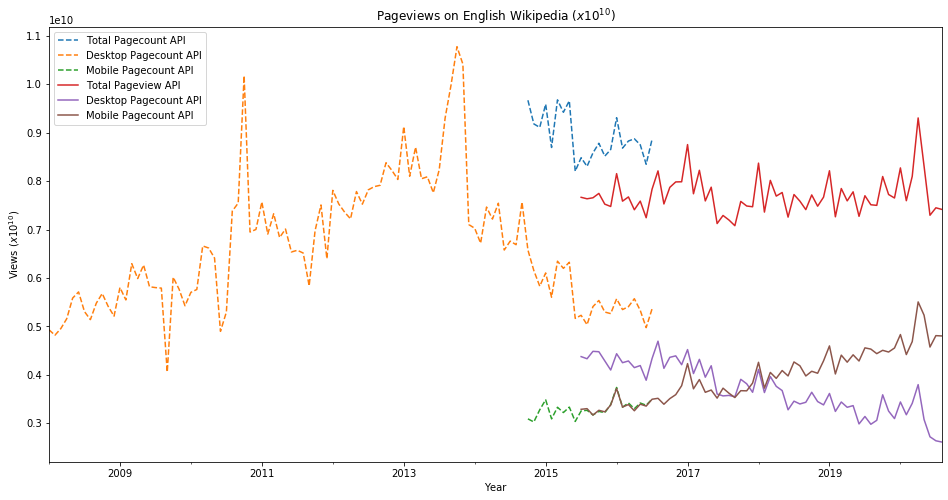

In [29]:
graph_cols = ['pagecount_all_views', 'pagecount_desktop_views',
              'pagecount_mobile_views', 'pageview_all_views',
              'pageview_desktop_views', 'pageview_mobile_views']
graph_title = "Pageviews on English Wikipedia ($x 10^{10}$)"
graph_legends = ["Total Pagecount API", "Desktop Pagecount API", "Mobile Pagecount API", "Total Pageview API", "Desktop Pagecount API", "Mobile Pagecount API"]
graph_styles = ["--", "--", "--", "-", "-", "-"]

ax = wiki_grouped.plot(x='timestamp_parsed', y=graph_cols, figsize=(16, 8), title=graph_title, style=graph_styles)
ax.set_xlabel("Year")
ax.set_ylabel("Views ($x 10^{10}$)")
ax.legend(graph_legends)